## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization, Dropout, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = BatchNormalization(name='BN'+str(i+1))(x)
            x = Activation('relu')(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = BatchNormalization(name='BN'+str(i+1))(x)
            x = Activation('relu')(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-8, 1e-12]
L2_EXP = [1e-8, 1e-12]
DROPOUT_EXP = [0.25, 0.50]
BATCH_SIZE = [16, 32]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1, l2, dropexp, batch_size in itertools.product(L1_EXP, L2_EXP, DROPOUT_EXP, BATCH_SIZE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %s, L2 = %s, DRP = %s, BN = %s" % (str(l1), str(l2), str(dropexp), str(batch_size)))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1, l2_ratio=l2, drp_ratio=dropexp)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "l1-%s-l2-%s-drp%s-bn%s" % (str(l1), str(l2), str(dropexp), str(batch_size))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 1e-08, L2 = 1e-08, DRP = 0.25, BN = 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
BN2 (BatchNormal

Epoch 44/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.0857 - acc: 0.6168 - val_loss: 1.2686 - val_acc: 0.5520
Epoch 45/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.0840 - acc: 0.6192 - val_loss: 1.2071 - val_acc: 0.5706
Epoch 46/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.0705 - acc: 0.6222 - val_loss: 1.2325 - val_acc: 0.5668
Epoch 47/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.0674 - acc: 0.6230 - val_loss: 1.2754 - val_acc: 0.5537
Epoch 48/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.0588 - acc: 0.6275 - val_loss: 1.2544 - val_acc: 0.5579
Epoch 49/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.0547 - acc: 0.6272 - val_loss: 1.2655 - val_acc: 0.5533
Epoch 50/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.0522 - acc: 0.6297 - val_loss: 1.2207 - val_acc: 0.5689
Experiment with L1 = 1e-08, L2 = 1

50000/50000 [==============================] - 29s 586us/step - loss: 1.0305 - acc: 0.6315 - val_loss: 1.3686 - val_acc: 0.5204
Epoch 37/50
50000/50000 [==============================] - 29s 585us/step - loss: 1.0209 - acc: 0.6346 - val_loss: 1.3188 - val_acc: 0.5336
Epoch 38/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.0149 - acc: 0.6411 - val_loss: 1.4181 - val_acc: 0.5100
Epoch 39/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.0049 - acc: 0.6413 - val_loss: 1.3417 - val_acc: 0.5370
Epoch 40/50
50000/50000 [==============================] - 29s 585us/step - loss: 0.9990 - acc: 0.6401 - val_loss: 1.2638 - val_acc: 0.5525
Epoch 41/50
50000/50000 [==============================] - 29s 585us/step - loss: 0.9903 - acc: 0.6454 - val_loss: 1.3700 - val_acc: 0.5277
Epoch 42/50
50000/50000 [==============================] - 29s 586us/step - loss: 0.9794 - acc: 0.6529 - val_loss: 1.2619 - val_acc: 0.5523
Epoch 43/50
50000/50000 [=======

50000/50000 [==============================] - 58s 1ms/step - loss: 1.4739 - acc: 0.4782 - val_loss: 1.3152 - val_acc: 0.5329
Epoch 29/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.4615 - acc: 0.4835 - val_loss: 1.3124 - val_acc: 0.5270
Epoch 30/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.4525 - acc: 0.4855 - val_loss: 1.3126 - val_acc: 0.5297
Epoch 31/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.4570 - acc: 0.4855 - val_loss: 1.2983 - val_acc: 0.5413
Epoch 32/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.4488 - acc: 0.4896 - val_loss: 1.3062 - val_acc: 0.5388
Epoch 33/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.4457 - acc: 0.4886 - val_loss: 1.3207 - val_acc: 0.5394
Epoch 34/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.4330 - acc: 0.4945 - val_loss: 1.3184 - val_acc: 0.5287
Epoch 35/50
50000/50000 [=====================

50000/50000 [==============================] - 29s 586us/step - loss: 1.4838 - acc: 0.4698 - val_loss: 1.3741 - val_acc: 0.4996
Epoch 21/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.4780 - acc: 0.4724 - val_loss: 1.4055 - val_acc: 0.4952
Epoch 22/50
50000/50000 [==============================] - 29s 585us/step - loss: 1.4655 - acc: 0.4819 - val_loss: 1.3561 - val_acc: 0.5144
Epoch 23/50
50000/50000 [==============================] - 29s 588us/step - loss: 1.4623 - acc: 0.4785 - val_loss: 1.3708 - val_acc: 0.5043
Epoch 24/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.4532 - acc: 0.4798 - val_loss: 1.3418 - val_acc: 0.5199
Epoch 25/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.4501 - acc: 0.4857 - val_loss: 1.3613 - val_acc: 0.5107
Epoch 26/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.4380 - acc: 0.4904 - val_loss: 1.3272 - val_acc: 0.5276
Epoch 27/50
50000/50000 [=======

50000/50000 [==============================] - 58s 1ms/step - loss: 1.3958 - acc: 0.5053 - val_loss: 1.3203 - val_acc: 0.5356
Epoch 13/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.3789 - acc: 0.5116 - val_loss: 1.3565 - val_acc: 0.5141
Epoch 14/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.3615 - acc: 0.5165 - val_loss: 1.3051 - val_acc: 0.5403
Epoch 15/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.3563 - acc: 0.5204 - val_loss: 1.2942 - val_acc: 0.5398
Epoch 16/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.3333 - acc: 0.5269 - val_loss: 1.4082 - val_acc: 0.4962
Epoch 17/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.3253 - acc: 0.5307 - val_loss: 1.2837 - val_acc: 0.5418
Epoch 18/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.3111 - acc: 0.5359 - val_loss: 1.3240 - val_acc: 0.5254
Epoch 19/50
50000/50000 [=====================

Epoch 5/50
50000/50000 [==============================] - 29s 588us/step - loss: 1.4984 - acc: 0.4635 - val_loss: 1.5261 - val_acc: 0.4407
Epoch 6/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.4581 - acc: 0.4787 - val_loss: 1.4248 - val_acc: 0.4856
Epoch 7/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.4383 - acc: 0.4844 - val_loss: 1.3595 - val_acc: 0.5165
Epoch 8/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.4099 - acc: 0.4956 - val_loss: 1.3657 - val_acc: 0.5135
Epoch 9/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.3862 - acc: 0.5062 - val_loss: 1.4222 - val_acc: 0.4905
Epoch 10/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.3650 - acc: 0.5125 - val_loss: 1.4378 - val_acc: 0.4835
Epoch 11/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.3445 - acc: 0.5201 - val_loss: 1.3677 - val_acc: 0.5122
Epoch 12/50
50000/50000 [

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 59s 1ms/step - loss: 2.0493 - acc: 0.2603 - val_loss: 1.7472 - val_acc: 0.3760
Epoch 2/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.8709 - acc: 0.3179 - val_loss: 1.6783 - val_acc: 0.4010
Epoch 3/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.8188 - acc: 0.3397 - val_loss: 1.6835 - val_acc: 0.3956
Epoch 4/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.7767 - acc: 0.3589 - val_loss: 1.6060 - val_acc: 0.4215
Epoch 5/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.7370 - acc: 0.3756 - val_loss: 1.5488 - val_acc: 0.4466
Epoch 6/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.7161 - acc: 0.3854 - val_loss: 1.5233 - val_acc: 0.4568
Epoch 7/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.6944 - acc: 0.3921 - val_loss: 1.5198 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 31s 613us/step - loss: 2.0979 - acc: 0.2503 - val_loss: 1.7536 - val_acc: 0.3765
Epoch 2/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.8520 - acc: 0.3244 - val_loss: 1.6601 - val_acc: 0.4115
Epoch 3/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.7853 - acc: 0.3546 - val_loss: 1.6120 - val_acc: 0.4181
Epoch 4/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.7462 - acc: 0.3678 - val_loss: 1.5735 - val_acc: 0.4434
Epoch 5/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.7136 - acc: 0.3826 - val_loss: 1.5390 - val_acc: 0.4485
Epoch 6/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.6865 - acc: 0.3904 - val_loss: 1.5292 - val_acc: 0.4495
Epoch 7/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.6614 - acc: 0.4040 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 59s 1ms/step - loss: 1.8774 - acc: 0.3279 - val_loss: 1.6394 - val_acc: 0.4209
Epoch 2/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.6921 - acc: 0.3977 - val_loss: 1.5079 - val_acc: 0.4686
Epoch 3/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.6252 - acc: 0.4224 - val_loss: 1.4655 - val_acc: 0.4790
Epoch 4/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.5819 - acc: 0.4363 - val_loss: 1.4318 - val_acc: 0.4947
Epoch 5/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.5408 - acc: 0.4514 - val_loss: 1.4381 - val_acc: 0.4751
Epoch 6/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.5091 - acc: 0.4635 - val_loss: 1.4342 - val_acc: 0.4857
Epoch 7/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.4888 - acc: 0.4693 - val_loss: 1.4144 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 31s 617us/step - loss: 1.8823 - acc: 0.3338 - val_loss: 1.6260 - val_acc: 0.4105
Epoch 2/50
50000/50000 [==============================] - 29s 590us/step - loss: 1.6626 - acc: 0.4049 - val_loss: 1.5438 - val_acc: 0.4633
Epoch 3/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.5910 - acc: 0.4307 - val_loss: 1.4787 - val_acc: 0.4684
Epoch 4/50
50000/50000 [==============================] - 29s 585us/step - loss: 1.5340 - acc: 0.4503 - val_loss: 1.5252 - val_acc: 0.4533
Epoch 5/50
50000/50000 [==============================] - 29s 585us/step - loss: 1.4919 - acc: 0.4676 - val_loss: 1.4600 - val_acc: 0.4758
Epoch 6/50
50000/50000 [==============================] - 29s 585us/step - loss: 1.4642 - acc: 0.4762 - val_loss: 1.4106 - val_acc: 0.4942
Epoch 7/50
50000/50000 [==============================] - 30s 592us/step - loss: 1.4348 - acc: 0.4877 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 59s 1ms/step - loss: 2.0467 - acc: 0.2591 - val_loss: 1.7478 - val_acc: 0.3763
Epoch 2/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.8661 - acc: 0.3192 - val_loss: 1.6951 - val_acc: 0.3836
Epoch 3/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.8137 - acc: 0.3434 - val_loss: 1.6222 - val_acc: 0.4223
Epoch 4/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.7748 - acc: 0.3606 - val_loss: 1.5780 - val_acc: 0.4360
Epoch 5/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.7438 - acc: 0.3743 - val_loss: 1.5380 - val_acc: 0.4548
Epoch 6/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.7130 - acc: 0.3838 - val_loss: 1.5375 - val_acc: 0.4568
Epoch 7/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.6896 - acc: 0.3951 - val_loss: 1.4991 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 31s 614us/step - loss: 2.0867 - acc: 0.2549 - val_loss: 1.7600 - val_acc: 0.3829
Epoch 2/50
50000/50000 [==============================] - 30s 593us/step - loss: 1.8493 - acc: 0.3273 - val_loss: 1.6776 - val_acc: 0.4085
Epoch 3/50
50000/50000 [==============================] - 29s 589us/step - loss: 1.7857 - acc: 0.3530 - val_loss: 1.6062 - val_acc: 0.4288
Epoch 4/50
50000/50000 [==============================] - 30s 599us/step - loss: 1.7462 - acc: 0.3695 - val_loss: 1.5933 - val_acc: 0.4382
Epoch 5/50
50000/50000 [==============================] - 30s 601us/step - loss: 1.7100 - acc: 0.3840 - val_loss: 1.5558 - val_acc: 0.4322
Epoch 6/50
50000/50000 [==============================] - 30s 604us/step - loss: 1.6813 - acc: 0.3979 - val_loss: 1.5304 - val_acc: 0.4528
Epoch 7/50
50000/50000 [==============================] - 33s 660us/step - loss: 1.6595 - acc: 0.4044 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 59s 1ms/step - loss: 1.8858 - acc: 0.3242 - val_loss: 1.5967 - val_acc: 0.4413
Epoch 2/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.6932 - acc: 0.3944 - val_loss: 1.5188 - val_acc: 0.4679
Epoch 3/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.6250 - acc: 0.4207 - val_loss: 1.4674 - val_acc: 0.4795
Epoch 4/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.5818 - acc: 0.4369 - val_loss: 1.4316 - val_acc: 0.4916
Epoch 5/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.5473 - acc: 0.4483 - val_loss: 1.4437 - val_acc: 0.4845
Epoch 6/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.5157 - acc: 0.4586 - val_loss: 1.3957 - val_acc: 0.5021
Epoch 7/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.4864 - acc: 0.4681 - val_loss: 1.3871 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 31s 615us/step - loss: 1.8754 - acc: 0.3306 - val_loss: 1.6178 - val_acc: 0.4235
Epoch 2/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.6566 - acc: 0.4075 - val_loss: 1.5267 - val_acc: 0.4559
Epoch 3/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.5905 - acc: 0.4298 - val_loss: 1.4683 - val_acc: 0.4724
Epoch 4/50
50000/50000 [==============================] - 29s 590us/step - loss: 1.5337 - acc: 0.4487 - val_loss: 1.4693 - val_acc: 0.4816
Epoch 5/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.4957 - acc: 0.4663 - val_loss: 1.4265 - val_acc: 0.4899
Epoch 6/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.4633 - acc: 0.4786 - val_loss: 1.3998 - val_acc: 0.5010
Epoch 7/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.4342 - acc: 0.4858 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 59s 1ms/step - loss: 2.0462 - acc: 0.2602 - val_loss: 1.7335 - val_acc: 0.3824
Epoch 2/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.8649 - acc: 0.3196 - val_loss: 1.6787 - val_acc: 0.3906
Epoch 3/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.8083 - acc: 0.3451 - val_loss: 1.5955 - val_acc: 0.4231
Epoch 4/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.7685 - acc: 0.3622 - val_loss: 1.5506 - val_acc: 0.4513
Epoch 5/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.7419 - acc: 0.3750 - val_loss: 1.5602 - val_acc: 0.4409
Epoch 6/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.7121 - acc: 0.3834 - val_loss: 1.5186 - val_acc: 0.4590
Epoch 7/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.6843 - acc: 0.3991 - val_loss: 1.4887 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 31s 615us/step - loss: 2.0859 - acc: 0.2601 - val_loss: 1.7636 - val_acc: 0.3778
Epoch 2/50
50000/50000 [==============================] - 29s 590us/step - loss: 1.8468 - acc: 0.3282 - val_loss: 1.6838 - val_acc: 0.3919
Epoch 3/50
50000/50000 [==============================] - 29s 590us/step - loss: 1.7811 - acc: 0.3545 - val_loss: 1.6188 - val_acc: 0.4190
Epoch 4/50
50000/50000 [==============================] - 29s 582us/step - loss: 1.7464 - acc: 0.3693 - val_loss: 1.5801 - val_acc: 0.4332
Epoch 5/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.7113 - acc: 0.3824 - val_loss: 1.5555 - val_acc: 0.4389
Epoch 6/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.6855 - acc: 0.3931 - val_loss: 1.5143 - val_acc: 0.4605
Epoch 7/50
50000/50000 [==============================] - 29s 587us/step - loss: 1.6560 - acc: 0.4026 - val_loss: 1.

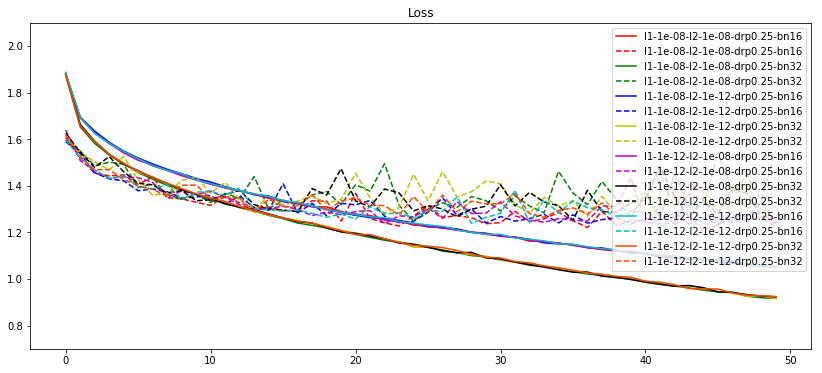

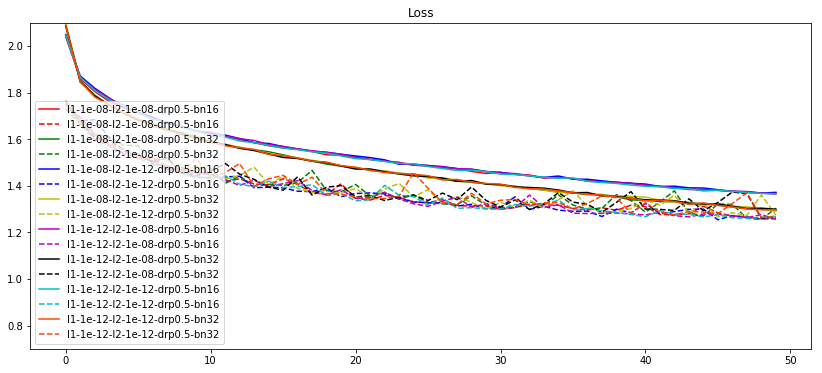

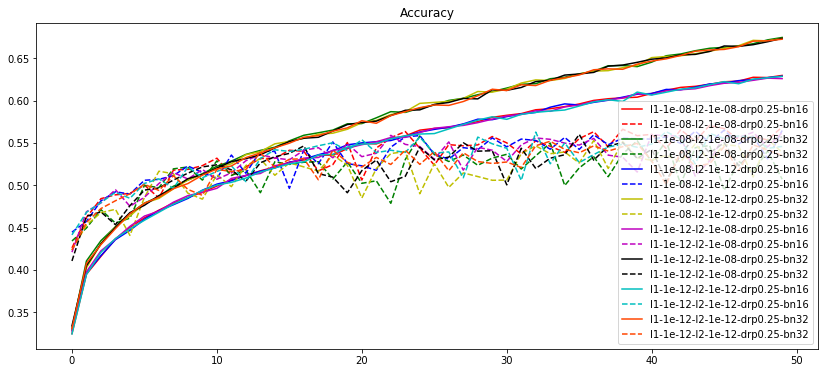

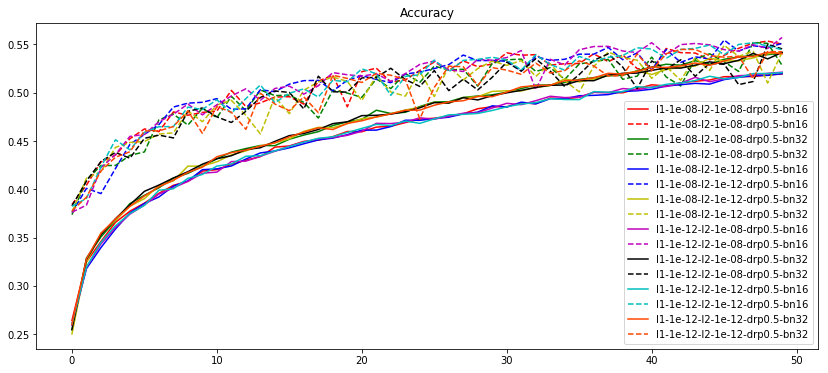

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "c", "orangered", "purple"]
keys = list(sorted(results.keys()))

plt.figure(figsize=(14,6))
for i, cond in enumerate([key for key in keys if str(DROPOUT_EXP[0]) in key]):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'],
             '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'],
             '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0.7, 2.1])
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
for i, cond in enumerate([key for key in keys if str(DROPOUT_EXP[1]) in key]):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'],
             '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'],
             '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0.7, 2.1])
plt.legend()
plt.show()


plt.figure(figsize=(14,6))
for i, cond in enumerate([key for key in keys if str(DROPOUT_EXP[0]) in key]):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'],
             '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'],
             '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
for i, cond in enumerate([key for key in keys if str(DROPOUT_EXP[1]) in key]):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'],
             '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'],
             '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()